# Trotterized Quantum Phase Estimation - Resource Estimates

In [4]:
from qualtran.bloqs.chemistry.trotter.trotterized_unitary import TrotterizedUnitary
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from qualtran.bloqs.phase_estimation import RectangularWindowState, TextbookQPE
import pandas as pd
import math
from qualtran import SoquetT

## Utilities

In [5]:
def convert_to_num_label(num):
    if num >= 1000000000000:
        return f"{num / 1000000000000:.1f} Trillion"
    elif num >= 1000000000:
        return f"{num / 1000000000:.1f} Billion"
    elif num >= 1000000:
        return f"{num / 1000000:.1f} Million"
    elif num >= 1000:
        return f"{num / 1000:.1f} K"
    

def convert_to_int(s):
    # Check if the last character is 'k'
    if s[-1].lower() == 'k':
        number = float(s[:-1])
        return int(number * 1000)
    elif s[-1].lower() == 'm':
       number = float(s[:-1])
       return int(number * 1000000)
    elif s[-1].lower() == 'g':
        number = float (s[:-1])
        return int(number * 1000000000)
    elif s[-1].lower() == 't':
        number = float (s[:-1])
        return int(number * 1000000000000)
    else:
        return int(s)
    
def convert_nanoseconds(nanoseconds):
    time_units = [
        ("centuries", 3153600000),
        ("decades", 315360000),
        ("years", 31536000),
        ("days", 86400),
        ("hours", 3600),
        ("mins", 60),
        ("secs", 1),
        ("millisecs", 1e-3),
        ("microsecs", 1e-6),
        ("nanosecs", 1e-9)
    ]
    seconds = nanoseconds * 1e-9  
    for unit, value in time_units:
        if seconds >= value:
            converted_value = seconds / value
            return f"{converted_value:.0f} {unit}"
    
    return f"{nanoseconds} nanosecs"

## Circuit Implementation Code

In [6]:
from functools import cached_property
from typing import Dict
from qualtran.bloqs.basic_gates import CNOT, Rx, Rz, Hadamard
from qualtran import Bloq, bloq_example, BloqBuilder, Signature, Soquet
import math
import attrs

@attrs.frozen
class SingleTermUnitary(Bloq):
    """
    Custom unitary that constructs a circuit for a single Hamiltonian term.
    
    Args:
        n_sites: no of qubits
        paulis: Tuple of Pauli strings (1 for X, 2 for Y, 3 for Z) for a single term.
        indices: Tuple of qubit indices on which the Pauli string acts.
        cnot_indices: Tuple of qubit indices for the CNOT gates.
        angle: Coefficient for the Hamiltonian term.
        timestep: The time step for the trotterization.
    """
    n_sites: int
    paulis : tuple[int, ...]
    indices: tuple[int, ...]
    cnot_indices: tuple[int, ...]
    angle: float 
    timestep: int = 1
    eps: float = 1e-10

    @cached_property
    def signature(self) -> Signature:
        return Signature.build(system=self.n_sites)
    
    def pretty_name(self) -> str:
        return 'U'

    def build_composite_bloq(self, bb: 'BloqBuilder', system: 'Soquet') -> Dict[str, 'Soquet']:
        try:
            # Split the system
            system = bb.split(system)

            p_i = len(self.paulis)
            for i in range(p_i):
                qubit_index = self.indices[i]
                Pval = self.paulis[i]
                if Pval == 1:  # X -> Hadamard gate
                    system[qubit_index] = bb.add(Hadamard(), q=system[qubit_index])
                elif Pval == 2:  # Y -> Rx(-pi/2)
                    system[qubit_index] = bb.add(Rx(round(-math.pi / 2, 2)), q=system[qubit_index])
                elif Pval == 0:  # Z -> No gate needed
                    pass

            # Apply the first set of CNOT gates
            n2 = len(self.cnot_indices)
            if n2 > 1:
                for j in range(n2 - 1):
                    system[self.cnot_indices[j]], system[self.cnot_indices[n2 - 1]] = bb.add(CNOT(), ctrl=system[self.cnot_indices[j]], target=system[self.cnot_indices[n2 - 1]])

            cofs = round((2.0 * self.angle), 2)
            system[self.cnot_indices[-1]] = bb.add(Rz(cofs, self.eps), q=system[self.cnot_indices[-1]])

            # Apply the second set of CNOT gates (in reverse order)
            if n2 > 1:
                for k in range(n2 - 1):
                    index = len(self.cnot_indices) - 2 - k
                    system[self.cnot_indices[index]], system[self.cnot_indices[n2 - 1]] = bb.add(CNOT(), ctrl=system[self.cnot_indices[index]], target=system[self.cnot_indices[n2 - 1]])

            # Apply the complex conjugate of the Pauli operations (inverse operations)
            for l in range(p_i):
                qubit_index = self.indices[l]
                Pval = self.paulis[l]
                if Pval == 1:  # X -> Hadamard gate
                    system[qubit_index] = bb.add(Hadamard(), q=system[qubit_index])
                elif Pval == 2:  # Y -> Rx(-pi/2)
                    system[qubit_index] = bb.add(Rx(round(-math.pi / 2, 2)), q=system[qubit_index])
                elif Pval == 0:  # Z -> No gate needed
                    pass

            return {'system': bb.join(system)}

        except Exception as e:
            # logging.error(f"Error occurred: {str(e)}")
            print(f"Paulis: {self.paulis}, Indices: {self.indices}, CNOT Indices: {self.cnot_indices}, Angle: {self.angle}, Eps: {self.eps}")
            raise e  # Re-raise the exception to propagate the error

    

@bloq_example
def _s_uni() -> SingleTermUnitary:
    sites = 2
    paulis = (1, 2)  # Pauli string [X, Y]
    indices = (0, 1)  # The qubits this term acts on
    cnot_ind = (0, 1)
    coefficient = 0.5  # Coefficient for this term
    ev_time = 0.640  # Time step
    s_uni = SingleTermUnitary(n_sites= sites, paulis=paulis, indices=indices,cnot_indices= cnot_ind, angle=coefficient, timestep=ev_time)
    return s_uni


## Trotterization with QPE

In [ ]:
# @attrs.frozen
# class MultiStageTrotter(TrotterizedUnitary):
#     def build_composite_bloq(self, bb: 'BloqBuilder', **soqs: SoquetT) -> Dict[str, 'SoquetT']:
#         for stage in range(self.timestep):
#            for i, a in zip(self.indices, self.coeffs):
#                soqs |= bb.add_d(attrs.evolve(self.bloqs[i], angle=2 * a * self.timestep), **soqs)  # type: ignore[misc]
#         return soqs


file_name = 'QRE-FeMoco/femoco_qubit_ham'
terms = 100000

with h5py.File("{}.hdf5".format(file_name), "r") as f:
    # Read the coefficients dataset
    coefficients = f['coefficients'][:terms]
    
    # Read the pauli_nums dataset
    pauli_nums = [np.array(sublist) for sublist in f['pauli_nums'][:terms]]
    
    # Read the indexs dataset
    indexs = [np.array(sublist) for sublist in f['indexs'][:terms]]
    
    # Read the cnot_indexs dataset
    cnot_indexs = [np.array(sublist) for sublist in f['cnot_indexs'][:terms]]

 
tuple_cof = tuple(coefficients)
tuple_paul = tuple(tuple(pauls)for pauls in pauli_nums)
tuple_ind = tuple(tuple(inds)for inds in indexs)
tuple_cnot = tuple(tuple(cnts)for cnts in cnot_indexs)


ev_time = 0.640 
orbitals = 76
trotterstep = int(orbitals**(3/2))

unitaries = []
n_terms = len(tuple_cof)
for i in range(n_terms):
    unitaries.append(SingleTermUnitary(orbitals,tuple_paul[i],tuple_ind[i],tuple_cnot[i],tuple_cof[i],ev_time))
tup_unit = tuple(unitaries)

trott_unitary = TrotterizedUnitary(
    bloqs=(tup_unit), 
    indices=tuple(range(n_terms)), 
    coeffs=tuple_cof, 
    timestep=trotterstep
)

qpe = TextbookQPE(trott_unitary,RectangularWindowState(10))


In [11]:
# from qualtran.drawing import show_bloq
# show_bloq(qpe,'musical_score')

## Resource Estimates

In [12]:
def get_bloq_logical_counts(bloq):
    from qsharp.estimator import LogicalCounts
    from qualtran._infra.gate_with_registers import get_named_qubits

    # This way of calculating the number of qubits will be inaccurate if a sub_bloq
    # allocates new qubits.
    num_qubits = bloq.signature.n_qubits()
    complexity = bloq.t_complexity()

    return LogicalCounts({
        "numQubits": num_qubits,
        "tCount": complexity.t,
        "rotationCount": complexity.rotations,
        "rotationDepth": complexity.rotations
    })

In [13]:
estimates = get_bloq_logical_counts(qpe).estimate([
    # {"qubitParams": {"name": "qubit_gate_ns_e3"}}
    {"errorBudget": 0.01,
    "qubitParams": {"name": "qubit_maj_ns_e6"},
    "qecScheme": {"name": "floquet_code"}}
    # {"qubitParams": {"name": "qubit_gate_ns_e4"}},
    # {"qubitParams": {"name": "qubit_maj_ns_e4"}, "surfaceCode": {"name": "floquet_code"}},
])


##################### Resource Estimates ########################

tcount = estimates.logical_counts._data['tCount'] * trotterstep
rotationcount = estimates.logical_counts._data['rotationCount'] * trotterstep
cczcount = estimates.logical_counts._data['cczCount']
ccixcount = estimates.logical_counts._data['ccixCount']
meas_count =  estimates.logical_counts._data['measurementCount']
total_gates = tcount + rotationcount + cczcount +ccixcount + meas_count
Single_Qubit_Measurement_Time = 100 #ns
log_value = math.log2(rotationcount / 0.0033333333333333335)
ress = 0.53 * log_value + 4.86
numtsperrotation = math.ceil(ress)
algodepth = meas_count + rotationcount + tcount + (3 * ccixcount) + (3 * cczcount) + (numtsperrotation * rotationcount)
logical_error_prob = 3.33e-3/(estimates['physicalCounts']['breakdown']['algorithmicLogicalQubits'] * algodepth)
numerator = 2 * math.log(0.07 / logical_error_prob)
denominator = math.log(0.01 /0.000001)
result = (numerator / denominator) - 1
cd = math.ceil(result)
code_distance = abs(cd) + 1 if cd%2==0 else abs(cd)
logical_cycle_time = 3 * Single_Qubit_Measurement_Time * code_distance
runtime = (algodepth * logical_cycle_time)

#############################################################

data = {
    "Orbitals": [orbitals],
    "Logical Qubits": [estimates['physicalCountsFormatted']['logicalCountsNumQubits']],
    "T-Gates": [convert_to_num_label(tcount)],
    "Logical Gates": [convert_to_num_label(total_gates)],
    # "Runtime":[estimates['physicalCountsFormatted']['runtime']]
    "Runtime":[convert_nanoseconds(runtime)]
}

# print(data)


## Results

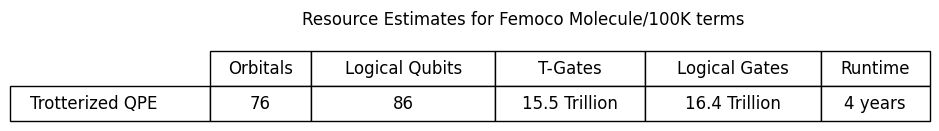

In [15]:

algorithms = ["Trotterized QPE"]
df = pd.DataFrame(data, index=algorithms)

fig, ax = plt.subplots(figsize=(8, 1))
ax.axis('off')

table = ax.table(
    cellText=df.values,
    rowLabels=df.index,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1], 
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(df.columns) + 1)))
for (row, col), cell in table.get_celld().items():
    cell.set_height(0.3) 

plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.1)
plt.title("Resource Estimates for Femoco Molecule/100K terms",pad=20)
plt.show()
